In [ ]:
# 피쳐 엔지니어링 - 피쳐 선택(다중 공선성 제거), 피쳐 추출(PCA, BGM) > 설명 수정

In [35]:
# 한글, 음수 시각화 설정

#시각화 패키지
import matplotlib.pyplot as plt

#시각화에서 한글을 사용하기 위한 설정
import platform
from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
    
#시각화에서 음수를 표현하기 위한 설정
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False 

import warnings
warnings.filterwarnings('ignore')

# 분류 모델

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
RD_sample_df = pd.read_csv('../data/RD_sample_df.csv', index_col= 0)
RD_sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2094 entries, 2016-02-22 23:00:00 to 2016-12-31 01:00:00
Data columns (total 98 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   X1WOS45106_PV                          2094 non-null   float64
 1   X1WOS45109_PV                          2094 non-null   float64
 2   DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV     2094 non-null   float64
 3   N2.TO.EA1313A.1FI33503A_PV             2094 non-null   float64
 4   ROOF.HEATING.Zone.1.1JIC31101.PV       2094 non-null   float64
 5   ROOF.HEATING.Zone.2.1JIC31102.PV       2094 non-null   float64
 6   ROOF.HEATING.Zone.3.1JIC31103.PV       2094 non-null   float64
 7   ROOF.HEATING.Zone.4.1JIC31104.PV       2094 non-null   float64
 8   ATM.FLOW.SECT.9.N2.1FIC33415.PV        2094 non-null   float64
 9   Gross.width                            2094 non-null   float64
 10  UPPER.AB1.Z1.TMP.1TIC41101.PV          2094 

In [7]:
X = RD_sample_df.iloc[:, :-1]
y= RD_sample_df['RD_defect']

X.shape

(2094, 97)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)
X_train.shape

(1675, 97)

In [ ]:
# 분류 모델

# 로지스틱 회귀
# 트리 기반 모델 : RandomForest, CatBoost
# 딥러닝 : 간단한 MLP

# 평가 지표
# ROC-AUC, Precision-Recall Curve, F1 Score 등

# Recall: 실제 불량 데이터 중 모델이 불량으로 예측한 비율

# 선형 모델

## 1. 로지스틱 회귀

# 트리 기반 모델

## 1. 랜덤포레스트

In [12]:
# Feature Importance
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators= 100, random_state= 42)
rf_clf.fit(X_train, y_train)

rf_importances = rf_clf.feature_importances_

rf_importance_df = pd.DataFrame({
  'feature' : X_train.columns,
  'importance' : rf_importances
})

# rf_importance_df.info()
rf_importance_df[:5]
rf_importance_df.sort_values(by= 'importance', ascending= False)[:10]['feature'].values

array(['ROLLDOWN.폐기.LEFT.', '폐기율...', 'ROOF.HEATING.Zone.1.1JIC31101.PV',
       'S_C2_C3_U_R', 'DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV',
       'TMP.TIN..BAY.1.LEFT.1TI30201.PV',
       'ROOF.HEATING.Zone57.1JIC31157.PV', 'N2.TO.EA1313B.1FI33527A_PV',
       'ATM.N2.H2.5..함유율.1CLFI33402_CPV', '투입.LEFT.'], dtype=object)

- 하이퍼 파라미터 튜닝

In [19]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100, 200, 300, 400],
    'max_depth' : [8, 10, 12]
}


estimator = RandomForestClassifier(random_state= 42)
grid_cv = GridSearchCV(estimator= estimator, param_grid= params, cv= 3)
grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)

{'max_depth': 10, 'n_estimators': 200}


In [ ]:
from sklearn.metrics import recall_score

best_rd_clf = grid_cv.best_estimator_
best_rd_clf.fit(X_train, y_train)

rd_preds = best_rd_clf.predict(X_test)

print('test 재현율 :', recall_score(y_test, rd_preds))

train 재현율 : 1.0
test 재현율 : 0.9619047619047619


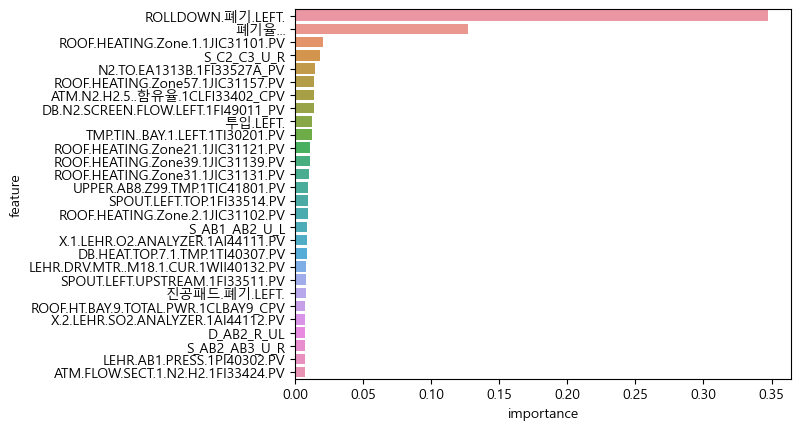

In [36]:
# 상위 28개의 피쳐 - PCA로 90%의 데이터 설명 가능
import seaborn as sns

feat_importance_df = pd.DataFrame({
  'feature' : X_train.columns,
  'importance' : best_rd_clf.feature_importances_
})

feat_importance_28 = feat_importance_df.sort_values(by= 'importance', ascending= False)[:28]
# print(feat_importance_28)

sns.barplot(x= feat_importance_28['importance'],
            y= feat_importance_28['feature'])
plt.show()

## 2. XG Boosting

In [ ]:
import xgboost as xgb

train_set = xgb.DMatrix(data= X_train, label= y_train)
test_set = xgb.DMatrix(data= X_test, label= y_test)

# 하이퍼 파라미터 생성
# objective에 이진 분류인지 멀티 클래스 분류인지 설정
params = {'max_depth' : 5, 'eta' : 0.1, # eta는 학습률
          'objective' : 'binary:logistic', 'eval_matric' : 'logloss'}
# 예측 횟수
num_rounds = 650

# 일반 그라디언트 부스팅은 예측기의 개수를 설정하면 조기종료하지 않고고무조건 예측기 개수만큼 훈련
wlist= [(train_set, 'train'), (test_set, 'test')]
xgb_model = xgb.train(params= params, dtrain= train_set, num_boost_round= num_rounds, 
                      evals= wlist, early_stopping_rounds= 30)

# depth= 3, eta= 0.1 :[499]	train-logloss:0.00170	test-logloss:0.00255
# depth= 5, eta= 0.1 : [499]	train-logloss:0.00152	test-logloss:0.00175
# depth= 7, eta= 0.1 : [499]	train-logloss:0.00152	test-logloss:0.00175
# depth= 7, eta= 0.01 : [499]	train-logloss:0.00793	test-logloss:0.00721
# depth= 10, eta= 0.1 : [499]	train-logloss:0.00152	test-logloss:0.00175

# depth= 5, eta= 0.1 : [599]	train-logloss:0.00145	test-logloss:0.00173
# depth= 5, eta= 0.1 : [606]	train-logloss:0.00145	test-logloss:0.00173


[0]	train-logloss:0.59993	test-logloss:0.59978
[1]	train-logloss:0.52333	test-logloss:0.52310
[2]	train-logloss:0.45930	test-logloss:0.45911
[3]	train-logloss:0.40507	test-logloss:0.40491
[4]	train-logloss:0.35867	test-logloss:0.35844
[5]	train-logloss:0.31863	test-logloss:0.31838
[6]	train-logloss:0.28387	test-logloss:0.28363
[7]	train-logloss:0.25351	test-logloss:0.25322
[8]	train-logloss:0.22687	test-logloss:0.22658
[9]	train-logloss:0.20341	test-logloss:0.20308
[10]	train-logloss:0.18268	test-logloss:0.18230


c:\Users\chjin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:29:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "eval_matric" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	train-logloss:0.16431	test-logloss:0.16393
[12]	train-logloss:0.14798	test-logloss:0.14757
[13]	train-logloss:0.13345	test-logloss:0.13304
[14]	train-logloss:0.12049	test-logloss:0.12005
[15]	train-logloss:0.10891	test-logloss:0.10844
[16]	train-logloss:0.09855	test-logloss:0.09808
[17]	train-logloss:0.08926	test-logloss:0.08877
[18]	train-logloss:0.08093	test-logloss:0.08041
[19]	train-logloss:0.07345	test-logloss:0.07294
[20]	train-logloss:0.06673	test-logloss:0.06622
[21]	train-logloss:0.06068	test-logloss:0.06017
[22]	train-logloss:0.05524	test-logloss:0.05473
[23]	train-logloss:0.05033	test-logloss:0.04982
[24]	train-logloss:0.04591	test-logloss:0.04540
[25]	train-logloss:0.04192	test-logloss:0.04142
[26]	train-logloss:0.03832	test-logloss:0.03777
[27]	train-logloss:0.03506	test-logloss:0.03452
[28]	train-logloss:0.03217	test-logloss:0.03161
[29]	train-logloss:0.02958	test-logloss:0.02902
[30]	train-logloss:0.02720	test-logloss:0.02664
[31]	train-logloss:0.02508	test-logloss:

In [24]:
from sklearn.metrics import recall_score

xgb_preds= xgb_model.predict(test_set)
print(np.round(xgb_preds[:10], 3)) # 1로 판정할 확률을 리턴함

xgb_preds = [1 if pred > 0.1 else 0 for pred in xgb_preds]
print(xgb_preds[:10])

print('재현율 :', recall_score(y_test, xgb_preds))

[1.    1.    0.    0.    0.    0.993 0.    0.999 1.    1.   ]
[1, 1, 0, 0, 0, 1, 0, 1, 1, 1]
재현율 : 1.0


In [ ]:
# 1.0????
# 한 번 다른 샘플 데이터로도 확인

## 3. MLP

In [ ]:
# 딥러닝 모델은 기본적으로 블랙박스 - shap를 활용하여 feature importance 파악악